### Импорты

In [ ]:
!pip install -U spacy --q
!python -m spacy download en_core_web_sm --q
!python -m spacy download ru_core_news_sm --q
!pip install typing_extensions==4.7.1 --upgrade --q
!pip install matplotlib
!pip install pymorphy3
!pip install typing_extensions==4.7.1 --upgrade --q
!python -m spacy download ru_core_news_sm --q
!pip install nltk
!pip install ufal.udpipe --q
!pip install conllu --q


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\janep\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


^C
^C


In [ ]:
!wget -q https://raw.githubusercontent.com/KatiaKozlova/files/refs/heads/main/57-10/syntax/model.py
!wget -q https://github.com/jwijffels/udpipe.models.ud.2.4/raw/refs/heads/master/inst/udpipe-ud-2.4-190531/russian-taiga-ud-2.4-190531.udpipe

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import json

import spacy
from spacy.lang.ru.examples import sentences
from spacy import displacy
from spacy.tokenizer import Tokenizer

from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import ufal.udpipe
from model import Model
import conllu
from nltk.parse import DependencyGraph

import warnings
import os
from collections import defaultdict, Counter


warnings.filterwarnings('ignore')


### **Задание 1 (UDPipe)**

1. Узнайте все про модификаторы слов **во всех формах**:
    - *рисунок*: найдите все его зависимые прилагательные,
    - *назвать*: найдите все его прямые дополнения и подлежащия,
    - *любить*: найдите все его зависимые наречия.

2. Достаньте из Arzamas все именные группы для слов с тегом `nsubj` (т.е. все именные группы в именительном падеже) и запишите их в файл, где каждая ИГ на новой строчке.

In [2]:
!wget -q https://linghub.ru/static/Taiga/Arzamas.zip
!unzip -q Arzamas.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
path = 'Arzamas/texts_tagged/'
files = [path + file for file in os.listdir(path)]

In [4]:
trees = []

for file in files:
    with open(file, encoding='utf-8') as text_f:
        parsed_sents = text_f.read().split('\n\n')

    for sent in parsed_sents:
        tree = [line for line in sent.split('\n') if line[0] != '#']
        trees.append('\n'.join(tree))

In [5]:
our_model = Model('russian-taiga-ud-2.4-190531.udpipe')

In [6]:
def all_modfiers(): # Очень наивный способ найти все названия модификаторов
    mods = []
    for tree in trees:
        d = DependencyGraph(tree)
        d.root = d.nodes[0]
        triples = list(d.triples())
        for e1, rel, e2 in triples:
            mods.append(rel)
    return set(mods)
print(all_modfiers())

{'mark', 'obl', 'nummod:entity', 'aux', 'dep', 'nsubj', 'fixed', 'conj', 'orphan', 'discourse', 'advmod', 'obl:agent', 'xcomp', 'flat:foreign', 'amod', 'root', 'case', 'nsubj:pass', 'obj', 'nummod:gov', 'acl', 'compound', 'nmod', 'nummod', 'acl:relcl', 'iobj', 'appos', 'punct', 'ccomp', 'parataxis', 'flat:name', 'aux:pass', 'cc', 'cop', 'advcl'}


In [7]:
def find_modifier(word: str, modif: list):
    word_forms = morph.parse(word)[0].lexeme
    modifiers = {}
    for mod in modif:
        modifiers[mod] = Counter()

    for tree in trees:
        d = DependencyGraph(tree)
        d.root = d.nodes[0]
        triples = list(d.triples())
        for e1, rel, e2 in triples:
            for w in word_forms:
                for r in modif:
                    if e1[0] == w.word and rel == r:
                        modifiers[rel][e2[0]] += 1  #Мы молчим про оптимальность...
    return modifiers
    

print(find_modifier(word='рисунок', modif = ['amod']))
print(find_modifier('назвать', modif = ['obj', 'nsubj', 'nsubj:pass']))
print(find_modifier(word='рисунок', modif = ['advmod']))


{'amod': Counter({'детских': 3, 'детские': 2, 'такие': 2, 'Этот': 2, 'Эротические': 2, 'классические': 2, 'старинный': 2, 'итальянский': 2, '2Рунический': 2, 'другие': 2, 'символические': 2, 'хиршфельдским': 1, 'детского': 1, 'классических': 1, 'выверенным': 1, 'бегущим': 1, 'собственных': 1, 'соседних': 1, 'эротических': 1, 'анатомическими': 1, 'играющие': 1, 'своими': 1, 'главных': 1, 'подготовительного': 1})}
{'obj': Counter({'себя': 4, 'ее': 3, 'это': 2, 'его': 2, 'книгу': 2, 'пьесу': 2, 'фильм': 1, 'Хомского': 1, 'костюм': 1, 'отца': 1, 'проект': 1, 'труд': 1, 'разорение': 1, 'перенесение': 1, 'которые': 1, 'механизм': 1, 'Вас': 1, 'которых': 1, 'сброд': 1, 'Джима': 1, 'имя': 1, 'знакомого': 1, 'лодку': 1, 'Киршона': 1, 'которую': 1, 'число': 1, 'Его': 1, 'телеканал': 1, 'Христа': 1, 'которого': 1, 'часовню': 1}), 'nsubj': Counter({'он': 4, 'я': 2, 'Афиногенов': 2, 'Иоанн': 2, 'Журнал': 1, 'Мы': 1, 'Шварц': 1, 'историки': 1, 'Пушкин': 1, 'платье': 1, 'кто-то': 1, 'соратник': 1, 'П

In [8]:
# Эта функция делает то же самое, но еще учитвает части речи. 
# Тк. не знаю, включает ли rel уже определение части речи, 
# но на всякий случай вот код с их учетом. 
# Кстати ответы получаютс одинаковыми :D

def find_modifier_pos(word:str, modif: str, grammem: str): # Условие для частей речи
    word_forms = morph.parse(word)[0].lexeme
    modifiers = Counter()
    for tree in trees:
        d = DependencyGraph(tree)
        d.root = d.nodes[0]
        triples = list(d.triples())
        for e1, rel, e2 in triples:
            for w in word_forms:
                if e1[0] == w.word and rel == modif and grammem in morph.parse(e2[0])[0].tag:
                    modifiers[e2[0]] += 1
    return modifiers
print(find_modifier_pos('рисунок', 'amod', 'ADJF'))
print(find_modifier_pos('любить', 'advmod', 'ADVB'))

Counter({'детских': 3, 'детские': 2, 'такие': 2, 'Этот': 2, 'Эротические': 2, 'классические': 2, 'старинный': 2, 'итальянский': 2, '2Рунический': 2, 'другие': 2, 'символические': 2, 'хиршфельдским': 1, 'детского': 1, 'классических': 1, 'собственных': 1, 'соседних': 1, 'эротических': 1, 'анатомическими': 1, 'своими': 1, 'главных': 1, 'подготовительного': 1})
Counter({'очень': 16, 'более': 3, 'чисто': 3, 'вообще': 2, 'уже': 2, 'сильно': 2, 'нежно': 2, 'никогда': 2, 'крепко': 2, 'особенно': 2, 'столь': 2, 'независимо': 1, 'бесконечно': 1, 'Очень': 1, 'страшно': 1, 'сначала': 1, 'потому': 1, 'горячо': 1, 'серьезно': 1, 'страстно': 1, 'слишком': 1, 'крайне': 1, 'Недаром': 1, 'Отдельно': 1, 'по-прежнему': 1, 'Сейчас': 1})


In [9]:
def find_nsubj():
    words = []
    for tree in trees:
        d = DependencyGraph(tree)
        d.root = d.nodes[0]
        nsubjs = []
        triples = list(d.triples())
        for e1, rel, e2 in triples:
            if rel == 'nsubj' or rel == 'nsubj:pass': # Если учитывать также пассивный субъект
                nsubjs.append(e2[0])
        words.append(nsubjs)
    return words
nsubjs = find_nsubj()

In [10]:
with open('nsubj.jsonl', 'w', encoding='utf-8') as f:
    for nsubj in nsubjs:
        f.write(json.dumps(nsubj, ensure_ascii=False) + "\n")


### **Задание 2 (Spacy)**

У вас есть первые две главы [английской](https://raw.githubusercontent.com/KatiaKozlova/files/refs/heads/main/57-10/syntax/hp1_en.txt) и [русской](https://raw.githubusercontent.com/KatiaKozlova/files/refs/heads/main/57-10/syntax/hp1_ru.txt) версии *Гарри Поттера и философского камня*.

1. Выделите все именнованные сущности в обеих версиях и сохраните их в два датафрейма со столбцами сущностями, типами сущностей и их кол-вом в тексте.
2. Сравните, насколько совпадают самые частотные сущности с тегами `LOC`, `ORG` и `PER(SON)` в англоязычной и русскоязычной версиях. Визуализируйте ваши наблюдения.
3. Для каждого человека (`PER(SON)`) найдите все его вершины-глаголы и сделайте частотный список их начальных форм как для английской версии, так и для русской. Также сравните и визуализируйте самые частотные результаты.

In [11]:
!wget https://raw.githubusercontent.com/KatiaKozlova/files/refs/heads/main/57-10/syntax/hp1_en.txt
!wget https://raw.githubusercontent.com/KatiaKozlova/files/refs/heads/main/57-10/syntax/hp1_ru.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
nlp_ru = spacy.load("ru_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

In [13]:
with open('hp1_en.txt', encoding = 'UTF-8') as text_f:
    en = text_f.read()
with open('hp1_ru.txt', encoding = 'UTF-8') as text_f:
    ru = text_f.read()

In [14]:
doc_en = nlp_en(en)
doc_ru = nlp_ru(ru)

In [15]:
# Словарик с данными
ents_ru = [{'word': morph.parse(doc_ru.ents[i].text)[0].normal_form, 'ner': doc_ru.ents[i].label_}  for i in range(len(doc_ru.ents)) if doc_ru.ents[i].label_ in nlp_ru.get_pipe('ner').labels ]
ents_en = [{'word': doc_en.ents[i].lemma_, 'ner': doc_en.ents[i].label_}  for i in range(len(doc_en.ents)) if doc_en.ents[i].label_ in nlp_en.get_pipe('ner').labels ]
df_ru = pd.DataFrame(ents_ru)
df_en = pd.DataFrame(ents_en)
# Датафрейм с подсчетом
df_ru_count = df_ru.groupby('word')[['word', 'ner']].value_counts().sort_values().reset_index()
df_en_count = df_en.groupby('word')[['word', 'ner']].value_counts().sort_values().reset_index()
# Для английского удалем ненужные типы
df_en_count = df_en_count.loc[df_en_count['ner'].isin(['ORG', 'LOC', 'PERSON'])]
df_en_count['ner'] = df_en_count['ner'].replace('PERSON', 'PER')
df_en_count['lang'] = 'en'
df_ru_count['lang'] = 'ru'
# Датафрейм с топ-5 каждого типа
df_en_top = df_en_count.groupby('ner').tail(5).reset_index()

df_ru_top = df_ru_count.groupby('ner').tail(5).reset_index()
result = pd.concat([df_ru_top, df_en_top], ignore_index=True)

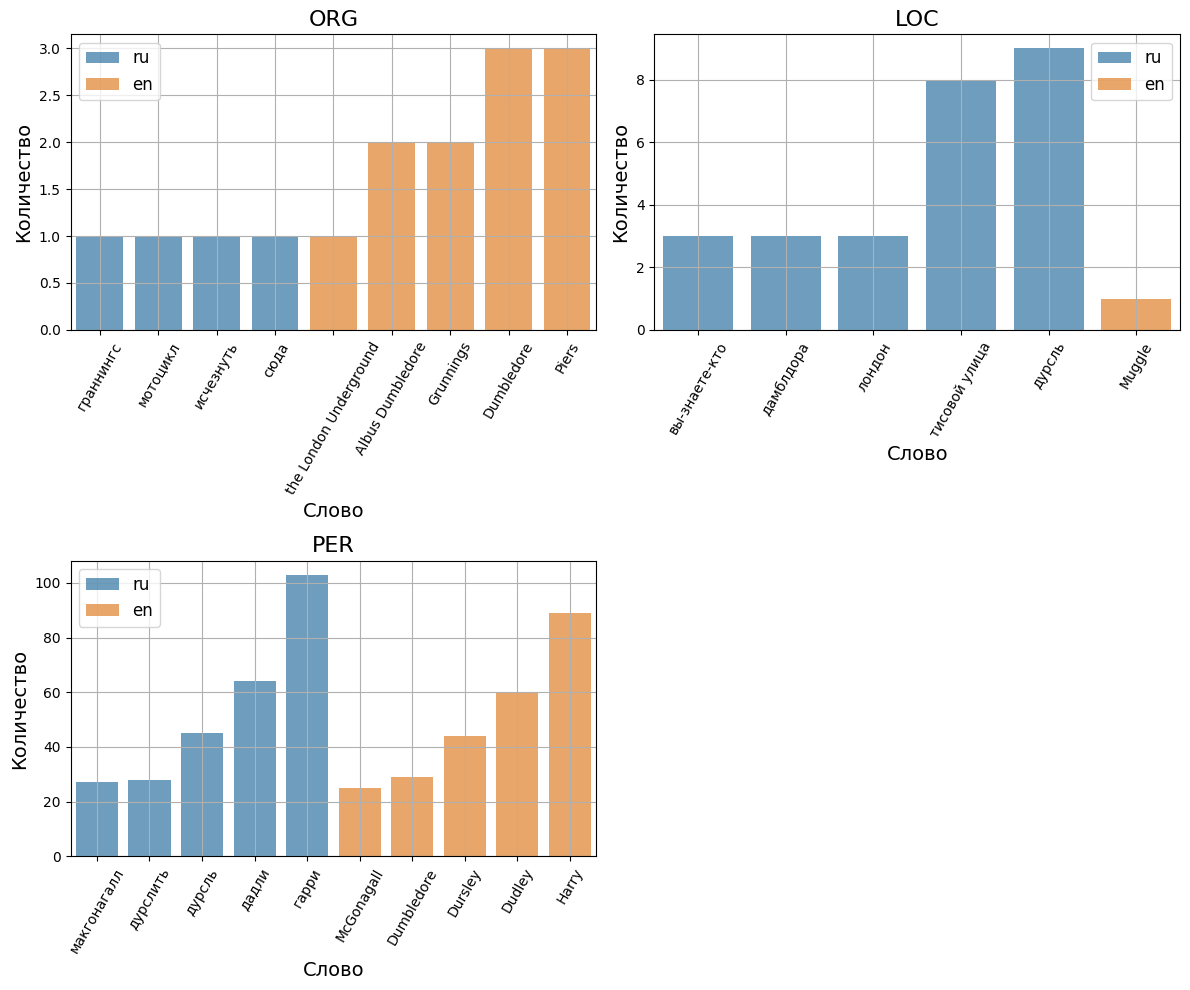

In [16]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.barplot(data=result.loc[result['ner'] == 'ORG'], x='word', y='count', alpha=0.7,hue='lang')
plt.xticks(rotation=60)
plt.legend(fontsize=12)
plt.title('ORG', fontsize=16)
plt.xlabel('Слово', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 2)
sns.barplot(data=result.loc[result['ner'] == 'LOC'], x='word', y='count', alpha=0.7,hue='lang')
plt.xticks(rotation=60)
plt.legend(fontsize=12)
plt.title('LOC', fontsize=16)
plt.xlabel('Слово', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 3)
sns.barplot(data=result.loc[result['ner'] == 'PER'], x='word', y='count', alpha=0.7,hue='lang')
plt.xticks(rotation=60)
plt.legend(fontsize=12)
plt.title('PER', fontsize=16)
plt.xlabel('Слово', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.subplots_adjust(wspace=0.25, hspace=1 )
plt.grid(True)
plt.tight_layout()
plt.show()


В первых двух главах везде самые популярные люди это Гарри, Дурсль, Дадли и Макгонагалл. Правда в английском Дамблдор потерялся в организациях. В обоих языках все плохо с локациями. С организациями все плохо в русском, в английском нормально

In [17]:
def roots(doc, lang: str) -> dict: # делаем словарик имя: список глаголов
    if lang == 'ru':
        person = 'PER'
    else:
        person = 'PERSON'
    verbs = {}
    for ent in doc.ents:
        if ent.label_ == person:
            for sent in doc.sents:  # красивого кода не будет.
                if ent.text in sent.text:
                    for token in sent:
                        if token.dep_ == 'ROOT':
                            ent_nf = ent.lemma_
                            tok_nf = token.lemma_
                            if ent_nf not in verbs:
                                verbs[ent_nf] = [tok_nf]
                            else:
                                verbs[ent_nf].append(tok_nf)
    return verbs

verbs_en = roots(doc_en, 'en')
verbs_ru = roots(doc_ru, 'ru')
                

In [18]:
def verb_to_df(data: dict):
    records = []
    for key, values in data.items():
        value_counts = Counter(values)
        for value, count in value_counts.items():
            records.append([key, value, count])
    df = pd.DataFrame(records, columns=['key', 'value', 'count'])
    key_counts = df.groupby('key')['count'].sum()
    top_keys = key_counts.nlargest(5).index  # Берем топ 5 Имен
    df_top = df[df['key'].isin(top_keys)]
    key_counts_vb = df_top.groupby('value')['count'].sum()
    top_values = key_counts_vb.nlargest(5).index  # Берем топ 5 глаголов
    df_top = df_top[df_top['value'].isin(top_values)]
    return df_top

verb_en_df = verb_to_df(verbs_en)
verb_ru_df = verb_to_df(verbs_ru)
hm_en = verb_en_df.pivot(index='key', columns='value', values='count')
hm_ru = verb_ru_df.pivot(index='key', columns='value', values='count')

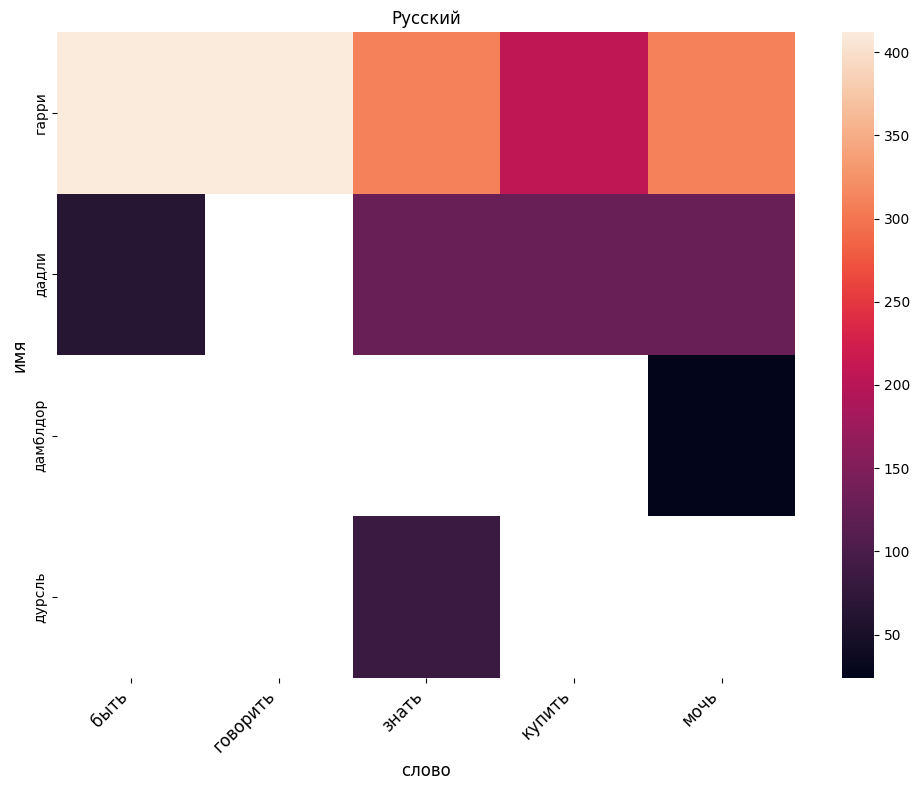

In [19]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(hm_ru)

plt.title('Русский')
plt.xlabel('слово', fontsize=12)
plt.ylabel('имя', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12) 
plt.tight_layout()
plt.show()

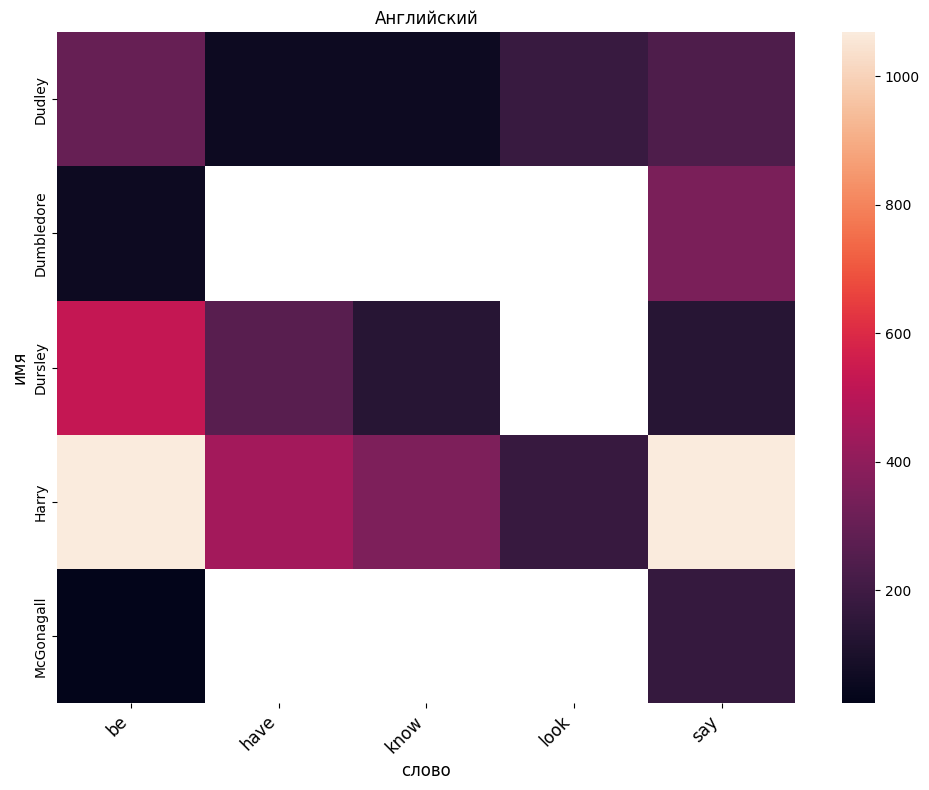

In [20]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(hm_en)

plt.title('Английский')
plt.xlabel('слово', fontsize=12)
plt.ylabel('имя', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12) 
plt.tight_layout()
plt.show()

Ура! Похоже на правду. Главный герой гарии больше всех говорит и "быть". ТАкже у него все глаголы свтлее чем у других персонажей. И даже значения глаголов в обоих текстах совпадают! Правда у меня получились разные шкалы, но в целом все совпадает.

### **Задание 3 (Spacy)\***

1. Дадим SpaCy на разбор предложение с синтаксической неоднозначностью. Какой анализ предлагает SpaCy?
    + *John saw the man on the mountain with a telescope.*
    + *I'm glad I'm a woman, and so is Lola.*

2. Дадим примеры на острова (приведены ниже с традиционной оценкой их приемлемости). Какой анализ предлагает SpaCy?
    - *What<sub>i</sub> does Sarah believe that Susan thinks that John bought \_<sub>i</sub>?*
    + Сложные ИГ
      - _<sup>\*</sup>Who<sub>i</sub> did Mary see the report that was about _<sub>i</sub>?_<br>(cf. *Mary saw the report that was about the senator.*)
      - _<sup>?*</sup>Which sportscar<sub>i</sub> did the color of _<sub>i</sub> delight the baseball player?_<br>(cf. *The color of the sportscar delighted the baseball player.*)

    + Комплементы глаголов говорения
       - _<sup>??</sup>What<sub>i</sub> did Mary whisper that Bill liked _<sub>i</sub>?_<br>(cf. *Mary whispered that Bill liked wine.*)

    + Остров подлежащего
        - _<sup>?*</sup>The sportscar which<sub>i</sub> the color of _<sub>i</sub> delighted the baseball player…_

3. Справляется ли SpaCy с эллипсисом:
    + *John can [play the guitar]<sub>i</sub>, and Mary can _<sub>i</sub>, too.*



In [21]:
from spacy import displacy

In [22]:
def syntax_analyzer(sen: str):
    doc = nlp_en(sen)
    displacy.render(doc, style='dep')
sens = ["John saw the man on the mountain with a telescope.",
        "I'm glad I'm a woman, and so is Lola.",
        "What does Sarah believe that Susan thinks that John bought?",
        "Who did Mary see the report that was about?",
        "Which sportscar did the color of delight the baseball player?",
        "What did Mary whisper that Bill liked?",
        "The sportscar which the color of delighted the baseball player.",
        "John can play the guitar, and Mary can, too."
                ]
for i in sens:
    syntax_analyzer(i)

1.1
+ *John saw the man on the mountain with a telescope.*
Джон на горе/ Человек на горе?
Приоритетно выбрал то что ближе к "горе"
Но почему-то не считает что человек с телескопом, а Джон с телескопом, хотя тот ближе??
1.2 
+ *I'm glad I'm a woman, and so is Lola.*
Я есть лола???
2.1  
- *What<sub>i</sub> does Sarah believe that Susan thinks that John bought \_<sub>i</sub>?
Получилось что "кто-то верит Sarah" , а не "Sarah верит во что-то"
Думает не к "that", а почему-то решили связать все три глагола
2.2.1
- _<sup>\*</sup>Who<sub>i</sub> did Mary see the report that was about _<sub>i</sub>?_<br>(cf. *Mary saw the report that was about the senator.*)
Нет свзи между who и about.
2.2.2
- Which sportscar<sub>i</sub> did the color of _<sub>i</sub> delight the baseball player?_<br>(cf. *The color of the sportscar delighted the baseball player.*)
Delighted стал существительным... - >цвет Delighted
Почему-то "игрок" - appos(уточнение) для "цвет"
2.3
- _<sup>??</sup>What<sub>i</sub> did Mary whisper that Bill liked _<sub>i</sub>?_<br>(cf. *Mary whispered that Bill liked wine.*)
"Понравилось" стало дополнением "прошептала" (в некоторой степени то да, но должна быть другая связь)

2.4
- _<sup>?*</sup>The sportscar which<sub>i</sub> the color of _<sub>i</sub> delighted the baseball player…
 Тут кажется правильная работа с островом!

3.1
  + *John can [play the guitar]<sub>i</sub>, and Mary can _<sub>i</sub>, too.
  Не очень справляется. Остров здесь - играть на гитаре, но получается что "тоже умеет играть марией"


В местах где есть острова он теряется и отмечает другие зависимые

Интересно, что у него почти никогда не пересекаются стрелочки, но могут быть вложенные стрелочки. Слабопроективные, получается...?